In [9]:
from fastai.vision import *
import warnings
warnings.filterwarnings('ignore')

path = untar_data(URLs.CAMVID)
print(path.ls()) # prints subdirectories

[PosixPath('/home/ruslan/.fastai/data/camvid/codes.txt'), PosixPath('/home/ruslan/.fastai/data/camvid/images'), PosixPath('/home/ruslan/.fastai/data/camvid/labels'), PosixPath('/home/ruslan/.fastai/data/camvid/valid.txt')]


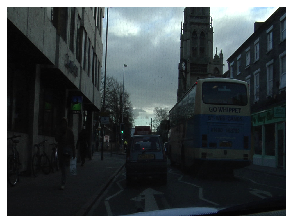

In [2]:
path_lbl = path/'labels'
path_img = path/'images'

fnames = get_image_files(path_img)
lbl_names = get_image_files(path_lbl)

# open and show image
img_f = fnames[10]
img = open_image(img_f)
img.show(figsize=(5, 5))

In [3]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

print(get_y_fn(img_f))

/home/ruslan/.fastai/data/camvid/labels/0001TP_006810_P.png


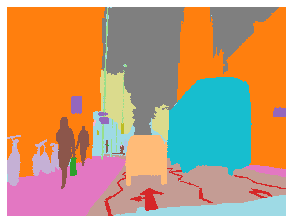

In [4]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5, 5), alpha=1)

In [7]:
codes = ["Animal", "Archway", "Bicyclist", "Bridge", "Building", "Car", "CartLuggagePram", "Child",
         "Column_Pole", "Fence", "LaneMkgsDriv", "LaneMkgsNonDriv", "Misc_Text", "MotorcycleScooter",
         "OtherMoving", "ParkingBlock", "Pedestrian", "Road", "RoadShoulder", "Sidewalk", "SignSymbol",
         "Sky", "SUVPickupTruck", "TrafficCone", "TrafficLight", "Train", "Tree", "Truck_Bus",
         "Tunnel", "VegetationMisc", "Void", "Wall"]

In [10]:
src_size = np.array(mask.shape[1:])
size = src_size//2
bs = 2

src = (SegmentationItemList.from_folder(path_img)
       # Load in x data from folder
       .split_by_fname_file('../valid.txt')
       # Split data into training and validation set 
       .label_from_func(get_y_fn, classes=codes)
       # Label data using the get_y_fn function
)

data = (src.transform(get_transforms(), size=size, tfm_y=True)
        # Flip images horizontally 
        .databunch(bs=bs)
        # Create a databunch
        .normalize(imagenet_stats)
        # Normalize for resnet
)

In [12]:
src

LabelLists;

Train: LabelList (600 items)
x: SegmentationItemList
Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480)
y: SegmentationLabelList
ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480)
Path: /home/ruslan/.fastai/data/camvid/images;

Valid: LabelList (101 items)
x: SegmentationItemList
Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480)
y: SegmentationLabelList
ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480)
Path: /home/ruslan/.fastai/data/camvid/images;

Test: None

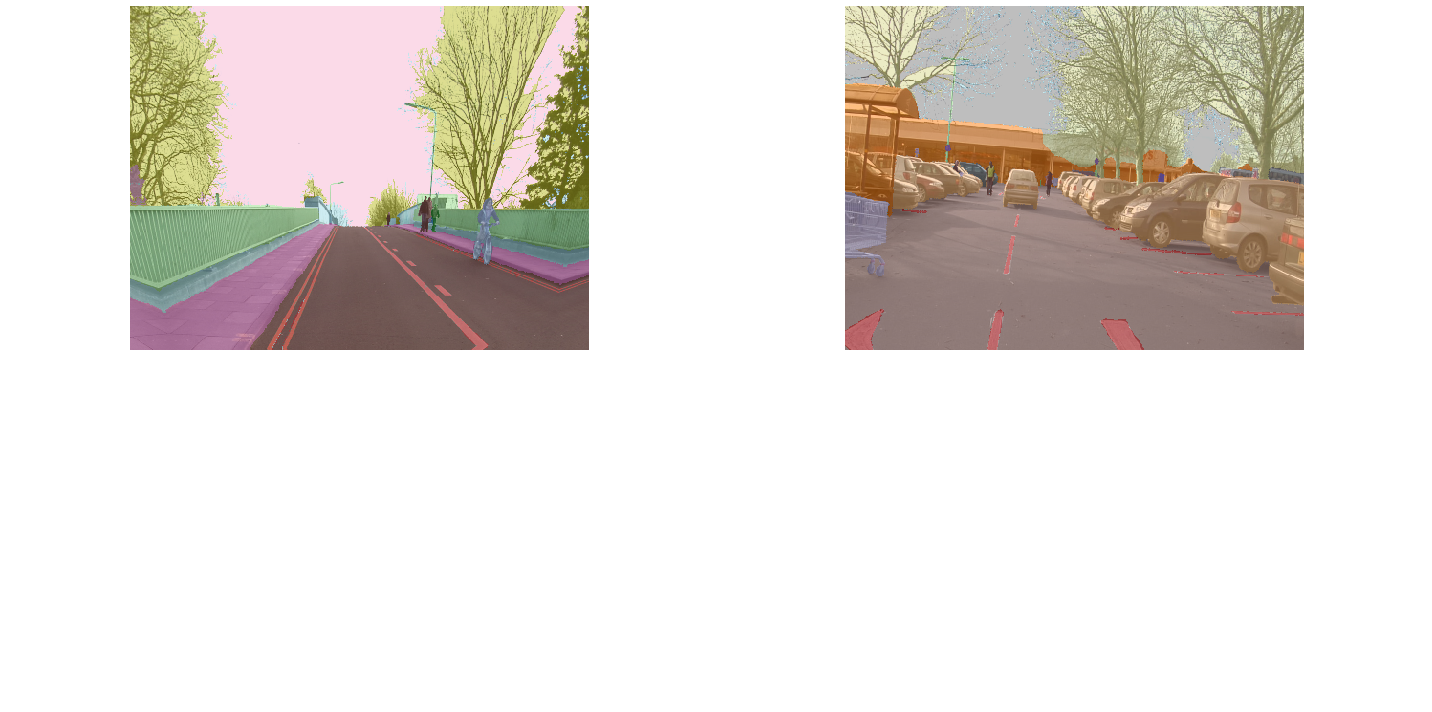

In [19]:
data.show_batch(rows=2, figsize=(20, 10))

In [22]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [24]:
learn = unet_learner(data, models.resnet34, metrics=acc_camvid, wd=1e-2)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


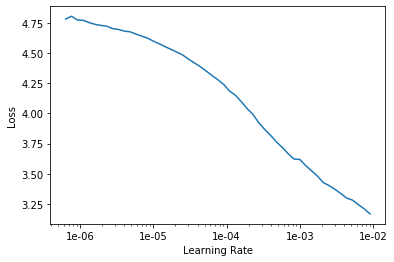

In [27]:
learn.lr_find() # find learning rate
learn.recorder.plot() # plot learning rate graph

In [28]:
lr = 3e-3 # pick a lr
learn.fit_one_cycle(10, slice(lr), pct_start=0.9) # train model

epoch,train_loss,valid_loss,acc_camvid,time
0,0.817658,0.610733,0.846201,00:50
1,0.731303,0.584022,0.849773,00:48
2,0.654735,0.563013,0.855655,00:48
3,0.604161,0.718908,0.862338,00:48
4,0.679302,0.828457,0.798092,00:48
5,0.596309,0.509955,0.863583,00:48
6,0.569522,0.447720,0.884101,00:48
7,0.541803,0.440569,0.873132,00:48
8,0.775978,0.622048,0.836586,00:48
9,0.510609,0.436711,0.876185,00:48


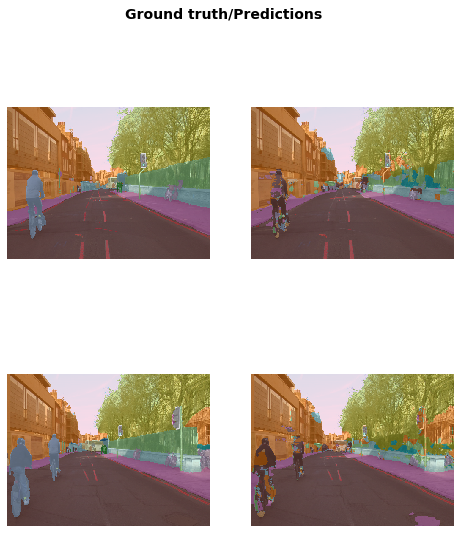

In [29]:
learn.save('camvid-stage-1') # save model
learn.show_results(rows=3, figsize=(8, 9)) # show results

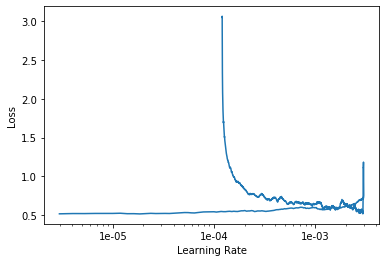

In [35]:
learn.unfreeze() # unfreeze all layers

# find and plot lr again
learn.recorder.plot()

In [36]:
# train model 
learn.fit_one_cycle(12, slice(lr/400, lr/4), pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.504035,0.422744,0.878670,00:52
1,0.484786,0.424473,0.879124,00:52
2,0.487215,0.416940,0.880382,00:52
3,0.484840,0.404456,0.890681,00:52
4,0.467012,0.416349,0.882713,00:52
5,0.452218,0.383814,0.892716,00:52
6,0.436085,0.390024,0.888914,00:52
7,0.448989,0.379508,0.891409,00:52
8,0.432372,0.387429,0.892532,00:52
9,0.467659,0.375274,0.894392,00:52


In [41]:
learn.save('camvid-stage-2')

## Test the model

In [42]:
learn.load('camvid-stage-2')

Learner(data=ImageDataBunch;

Train: LabelList (600 items)
x: SegmentationItemList
Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480)
y: SegmentationLabelList
ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480)
Path: /home/ruslan/.fastai/data/camvid/images;

Valid: LabelList (101 items)
x: SegmentationItemList
Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480)
y: SegmentationLabelList
ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480)
Path: /home/ruslan/.fastai/data/camvid/images;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats

Inference took 0.0696 [sec]
Output image shape: torch.Size([3, 360, 480])


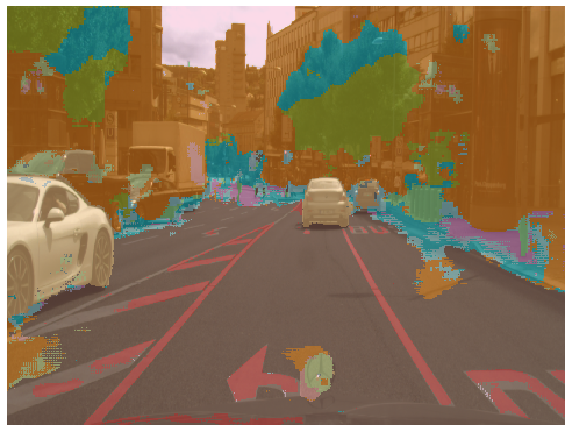

In [52]:
test_img = open_image('/home/ruslan/Desktop/example_images/example_04.png')

import time
start = time.time()
output = learn.predict( test_img )
print('Inference took %.4f [sec]'%(time.time()-start))

test_resized = test_img.apply_tfms(None, size=output[0].shape)
print('Output image shape:', test_resized.shape)

test_resized.show(figsize=(10,10), y=learn.predict(test_resized)[0])